# [TUM - miniprojekt] Przebieg procesu uczenia dla sieci przy użyciu różnych algorytmów optymalizacji

## Autorzy: Agnieszka Klimek (145302), Anna Prałat (145395)


In [1]:
# %pip install torch torchvision tqdm pandas matplotlib scikit-learn

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [3]:
DATASET_PATH: str = "./datasets"
MODEL_PATH: str = "./models"
RESULT_PATH: str = "./results"

BATCH_SIZE: int = 4

In [4]:
def get_dataset(dataset, batch_size: int = BATCH_SIZE) -> tuple:
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    train_set = dataset(root=DATASET_PATH, download=True, transform=transform, train=True)
    valid_set = dataset(root=DATASET_PATH, download=True, transform=transform, train=False)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader

In [5]:
datasets = {
    "FashionMNIST": torchvision.datasets.FashionMNIST,
    "MNIST": torchvision.datasets.MNIST,
}

In [6]:
device = torch.device(
    "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
)
print(device)


class CNNClassifier(nn.Module):
    def __init__(self, number_of_channels: int = 1, number_of_classes: int = 10) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(number_of_channels, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, number_of_classes)

    def forward(self, x) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

mps


In [7]:
optimizers = {
    "SGD": optim.SGD,
    "AdaGrad": optim.Adagrad,
    "Adam": optim.Adam,
    "AdamW": optim.AdamW,
    "RMSprop": optim.RMSprop,
}

In [8]:
loss_fn = nn.CrossEntropyLoss()


def train_epoch(model, train_loader, optimizer, lr: float = 1e-3) -> float:
    model.train()
    optimizer = optimizer(model.parameters(), lr=lr)

    running_loss = 0.0
    # avg_loss = 0.0
    for i, data in enumerate(tqdm(train_loader)):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # if i % 1000 == 999:
        #     avg_loss = running_loss / 1000
        #     print(f"[{i + 1:5d}] loss: {avg_loss:.3f}")
        #     running_loss = 0.0

    avg_loss = running_loss / (i + 1)
    return avg_loss


def valid_epoch(model, valid_loader) -> float:
    model.eval()

    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(tqdm(valid_loader)):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

    avg_loss = running_loss / (i + 1)
    return avg_loss

In [9]:
NUMBER_OF_EPOCHS: int = 100
EPOCHS_WITHOUT_IMPROVEMENT: int = 2

In [10]:
def train_models():
    for dataset_name, dataset in datasets.items():
        print(f"DATASET: {dataset_name}")
        train_loader, valid_loader = get_dataset(dataset)

        for optimizer_name, optimizer in optimizers.items():
            print(f"OPTIMIZER: {optimizer_name}")

            model = CNNClassifier()
            model.to(device)

            best_vloss = np.inf
            best_vloss_epoch = 0

            results: list = []

            for epoch_number in range(NUMBER_OF_EPOCHS):
                print(f"EPOCH: {epoch_number + 1} / {NUMBER_OF_EPOCHS}")

                avg_loss = train_epoch(model, train_loader, optimizer)

                avg_vloss = valid_epoch(model, valid_loader)

                results.append(
                    {
                        "epoch": epoch_number,
                        "train_loss": avg_loss,
                        "valid_loss": avg_vloss,
                    }
                )

                print(f"Train Loss: {avg_loss:.3f}, Valid Loss: {avg_vloss:.3f}")

                if avg_vloss < best_vloss:
                    best_vloss = avg_vloss
                    best_vloss_epoch = epoch_number
                    if not os.path.exists(MODEL_PATH):
                        os.makedirs(MODEL_PATH)
                    torch.save(
                        model.state_dict(),
                        f"{MODEL_PATH}/{dataset_name}_{optimizer_name}_model.pth",
                    )
                elif epoch_number - best_vloss_epoch >= EPOCHS_WITHOUT_IMPROVEMENT:
                    print(
                        f"Early stopping (no improvement in validation loss in epoch {epoch_number + 1})"
                    )
                    break

            results_df = pd.DataFrame(results)
            if not os.path.exists(RESULT_PATH):
                os.makedirs(RESULT_PATH)
            results_df.to_csv(
                f"{RESULT_PATH}/{dataset_name}_{optimizer_name}_results.csv", index=False
            )


if not os.path.exists(RESULT_PATH):
    train_models()

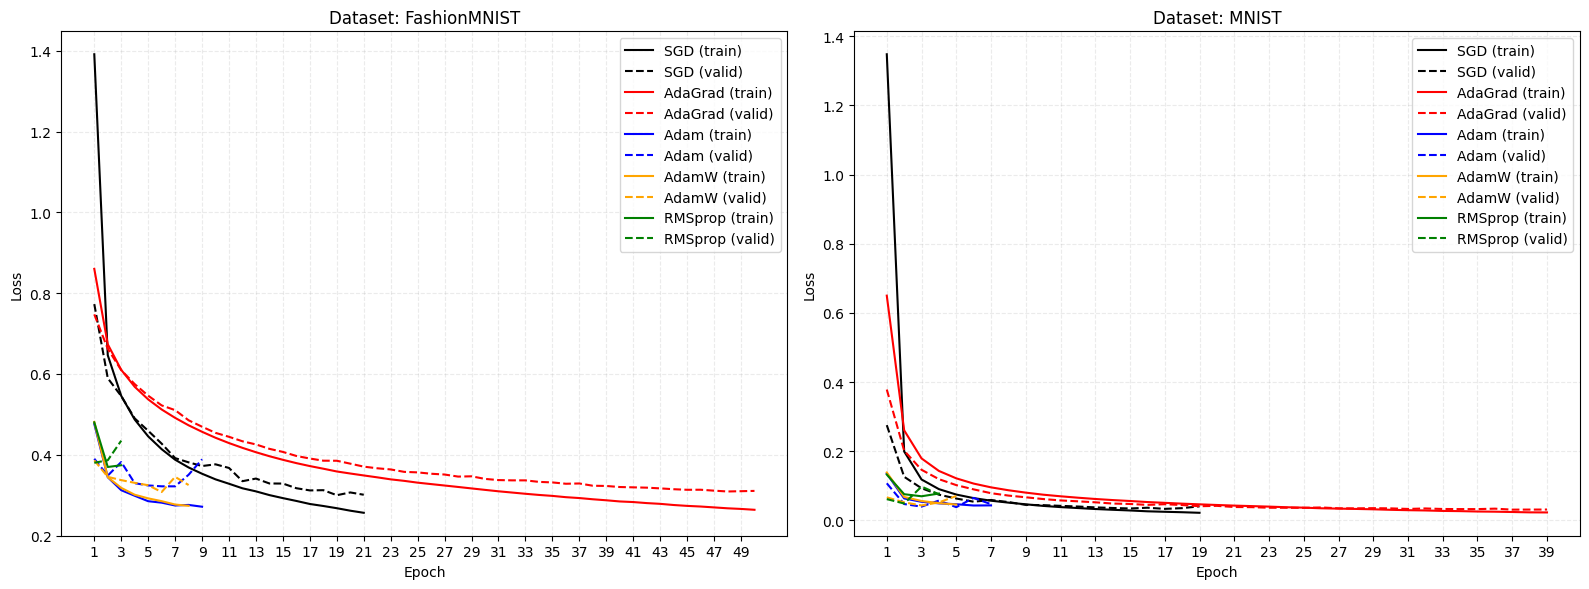

In [11]:
cols = len(datasets)
fig, ax = plt.subplots(nrows=1, ncols=cols, figsize=(8 * cols, 6), tight_layout=True)
colors = ["black", "red", "blue", "orange", "green"]

for dataset_idx, (dataset_name, dataset) in enumerate(datasets.items()):
    max_epochs = 0
    for optimizer_idx, (optimizer_name, optimizer) in enumerate(optimizers.items()):
        results_df = pd.read_csv(f"{RESULT_PATH}/{dataset_name}_{optimizer_name}_results.csv")
        ax[dataset_idx].plot(
            results_df["epoch"] + 1,
            results_df["train_loss"],
            label=f"{optimizer_name} (train)",
            color=colors[optimizer_idx],
        )
        ax[dataset_idx].plot(
            results_df["epoch"] + 1,
            results_df["valid_loss"],
            label=f"{optimizer_name} (valid)",
            color=colors[optimizer_idx],
            linestyle="--",
        )
        if len(results_df["epoch"]) > max_epochs:
            max_epochs = len(results_df["epoch"])

    ax[dataset_idx].set_title(f"Dataset: {dataset_name}")
    ax[dataset_idx].set_xticks(np.arange(1, max_epochs + 1, step=2))
    ax[dataset_idx].set_xlabel("Epoch")
    ax[dataset_idx].set_ylabel("Loss")
    ax[dataset_idx].grid(linestyle="--", alpha=0.25)
    ax[dataset_idx].legend()

fig.savefig(f"{RESULT_PATH}/plot_loss.png")

In [12]:
def calculate_accuracy(model, data_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy


results = []
for dataset_name, dataset in datasets.items():
    print(f"DATASET: {dataset_name}")
    train_loader, valid_loader = get_dataset(dataset)

    for optimizer_name, optimizer in optimizers.items():
        print(f"OPTIMIZER: {optimizer_name}")

        model = CNNClassifier()
        model.to(device)

        model_path = f"{MODEL_PATH}/{dataset_name}_{optimizer_name}_model.pth"
        if os.path.exists(model_path):
            model.load_state_dict(torch.load(model_path, map_location=device))
        else:
            print(f"No saved model found for {dataset_name} and {optimizer_name}")
            continue

        accuracy = calculate_accuracy(model, valid_loader)
        results.append({"dataset": dataset_name, "optimizer": optimizer_name, "accuracy": accuracy})

results_df = pd.DataFrame(results)
print(results_df)

DATASET: FashionMNIST
OPTIMIZER: SGD
OPTIMIZER: AdaGrad
OPTIMIZER: Adam
OPTIMIZER: AdamW
OPTIMIZER: RMSprop
DATASET: MNIST
OPTIMIZER: SGD
OPTIMIZER: AdaGrad
OPTIMIZER: Adam
OPTIMIZER: AdamW
OPTIMIZER: RMSprop
        dataset optimizer  accuracy
0  FashionMNIST       SGD    0.8935
1  FashionMNIST   AdaGrad    0.8915
2  FashionMNIST      Adam    0.8883
3  FashionMNIST     AdamW    0.8901
4  FashionMNIST   RMSprop    0.8650
5         MNIST       SGD    0.9887
6         MNIST   AdaGrad    0.9891
7         MNIST      Adam    0.9876
8         MNIST     AdamW    0.9882
9         MNIST   RMSprop    0.9862


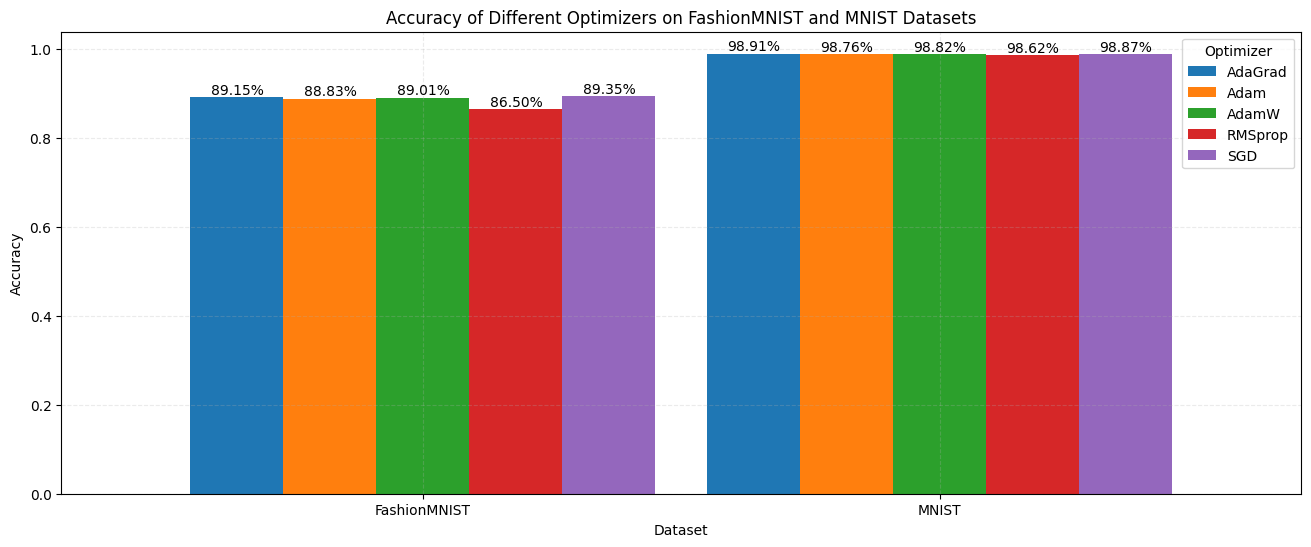

In [13]:
grouped = results_df.pivot(index="dataset", columns="optimizer", values="accuracy")

ax = grouped.plot(kind="bar", figsize=(16, 6), width=0.9)
for p in ax.patches:
    ax.annotate(
        f"{p.get_height() * 100:.2f}%",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
    )

plt.xlabel("Dataset")
plt.ylabel("Accuracy")
plt.title("Accuracy of Different Optimizers on FashionMNIST and MNIST Datasets")
plt.xticks(rotation=0)
plt.grid(linestyle="--", alpha=0.25)
plt.legend(title="Optimizer")

plt.savefig(f"{RESULT_PATH}/plot_accuracy.png")
plt.show()

In [14]:
def predict(images, model):
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    return predicted.cpu().numpy()


def get_validation_images_and_labels(valid_loader, num_images=5):
    images, labels = next(iter(valid_loader))
    images = images[:num_images]
    labels = labels[:num_images]
    return images, labels


fashion_mnist_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

DATASET: FashionMNIST


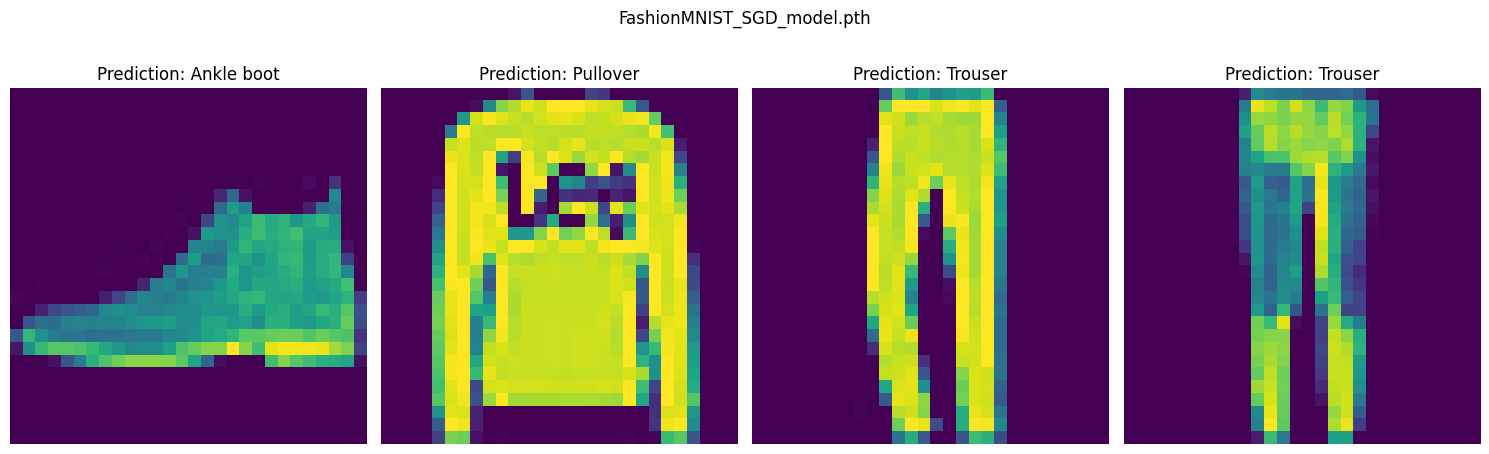

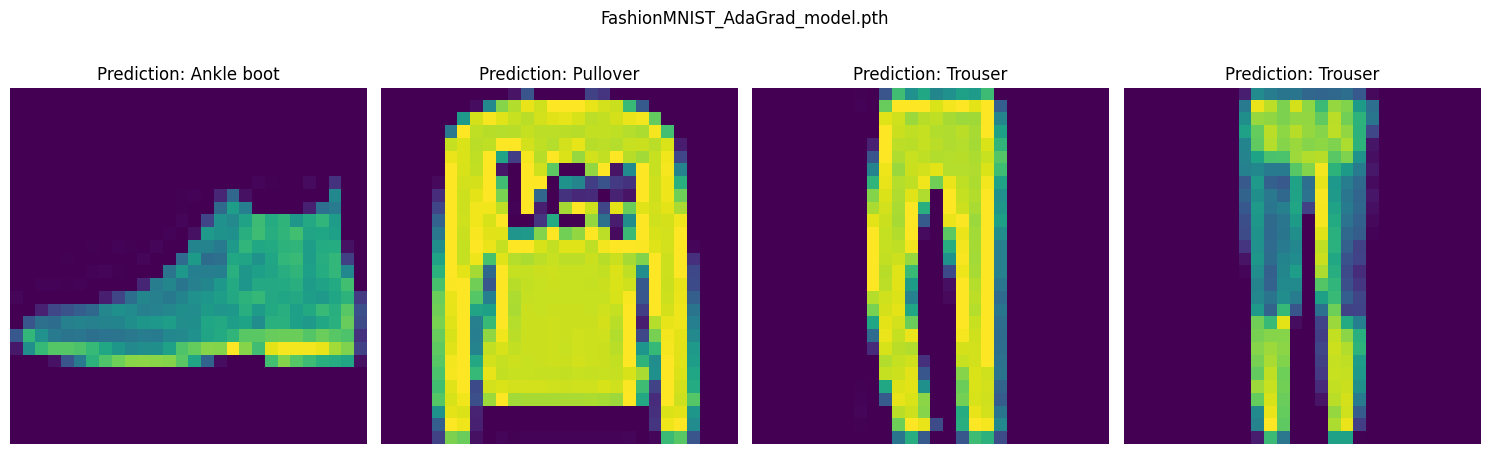

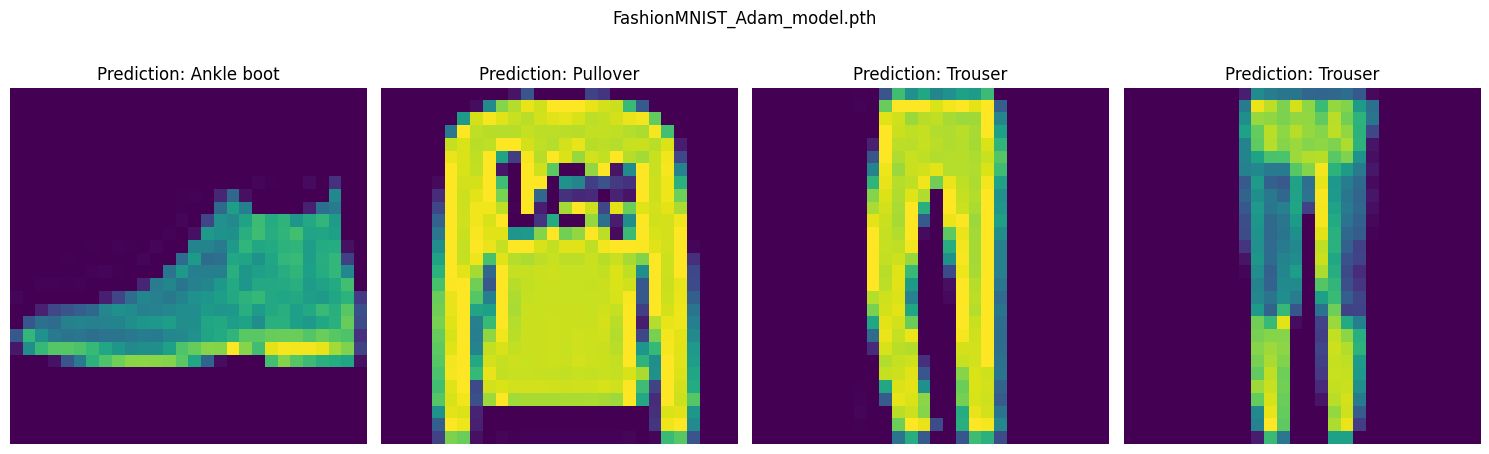

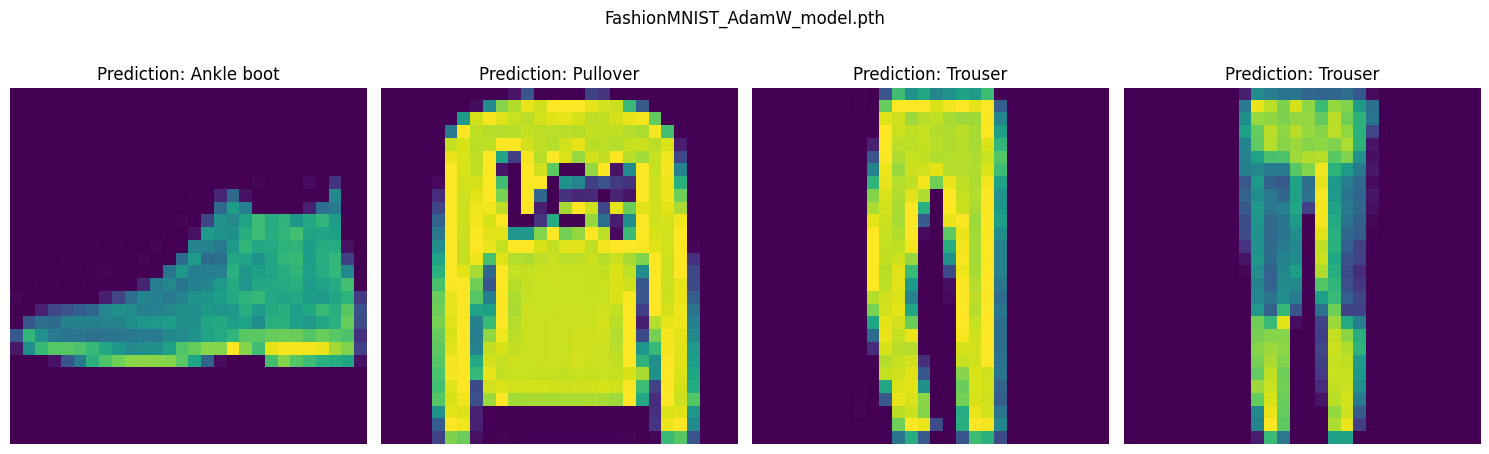

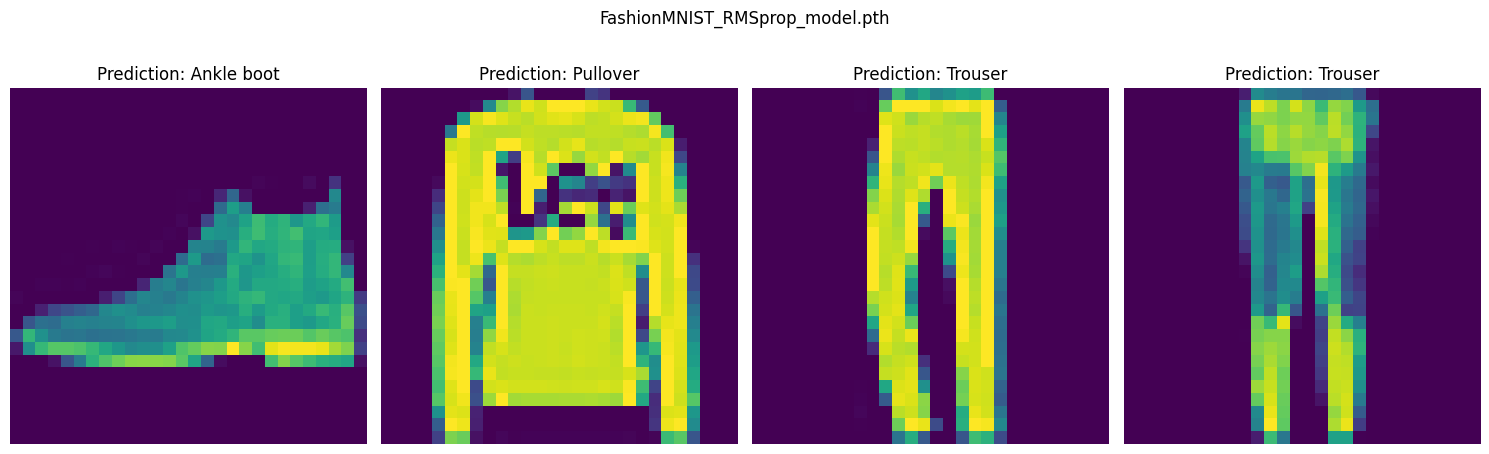

DATASET: MNIST


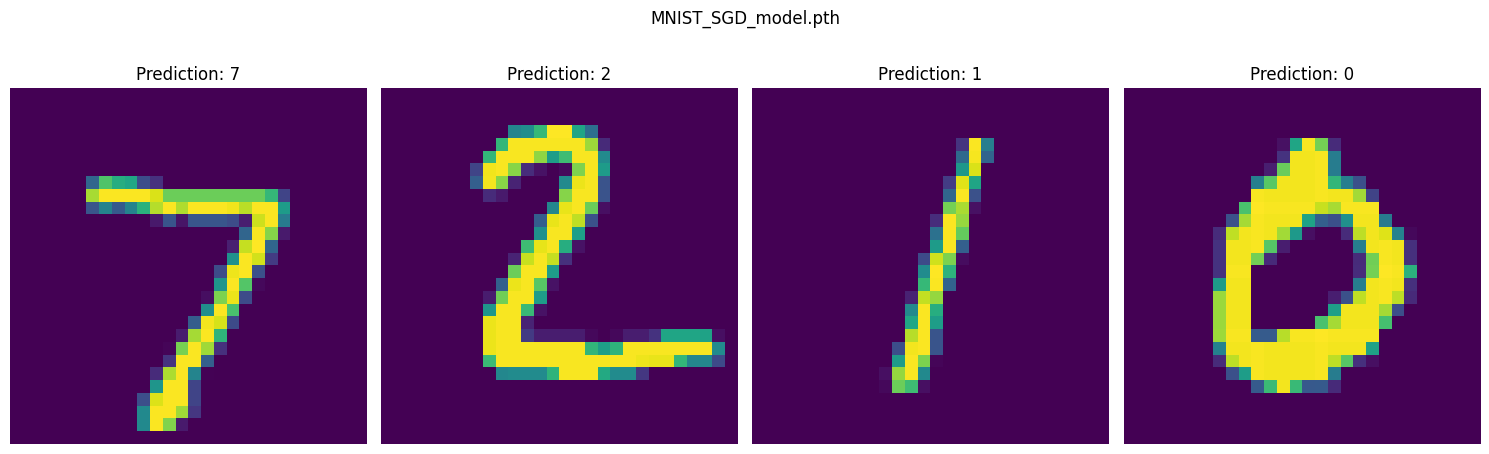

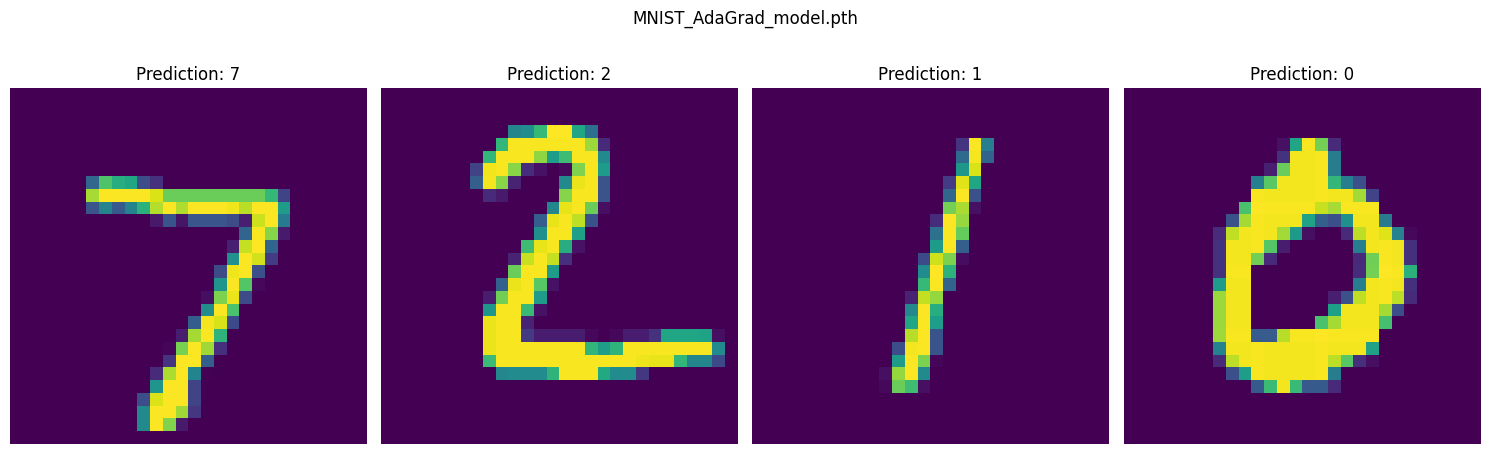

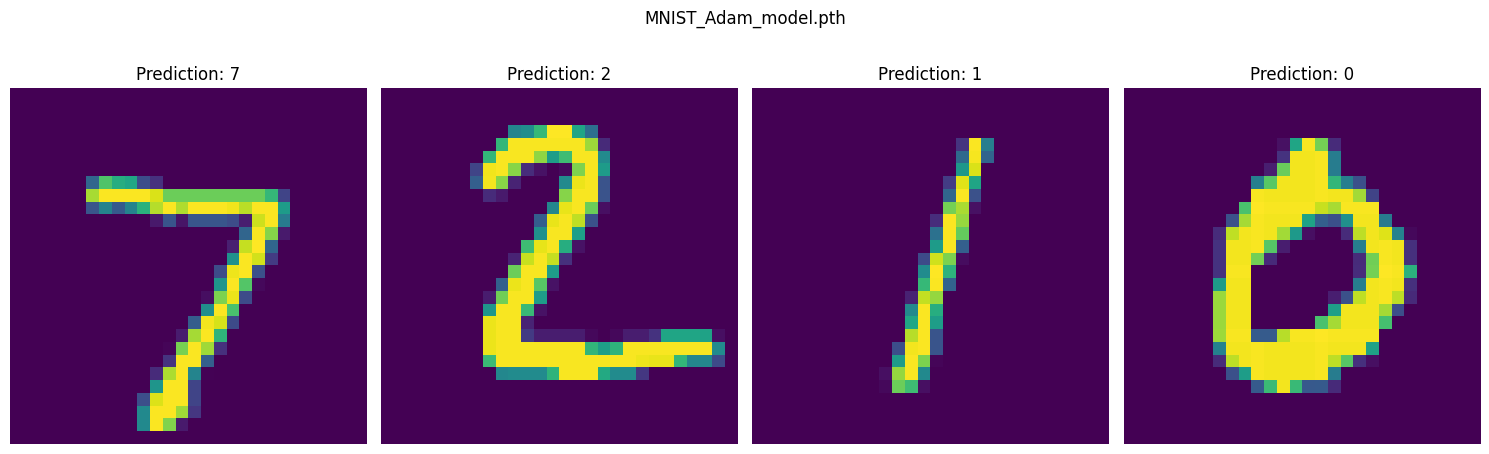

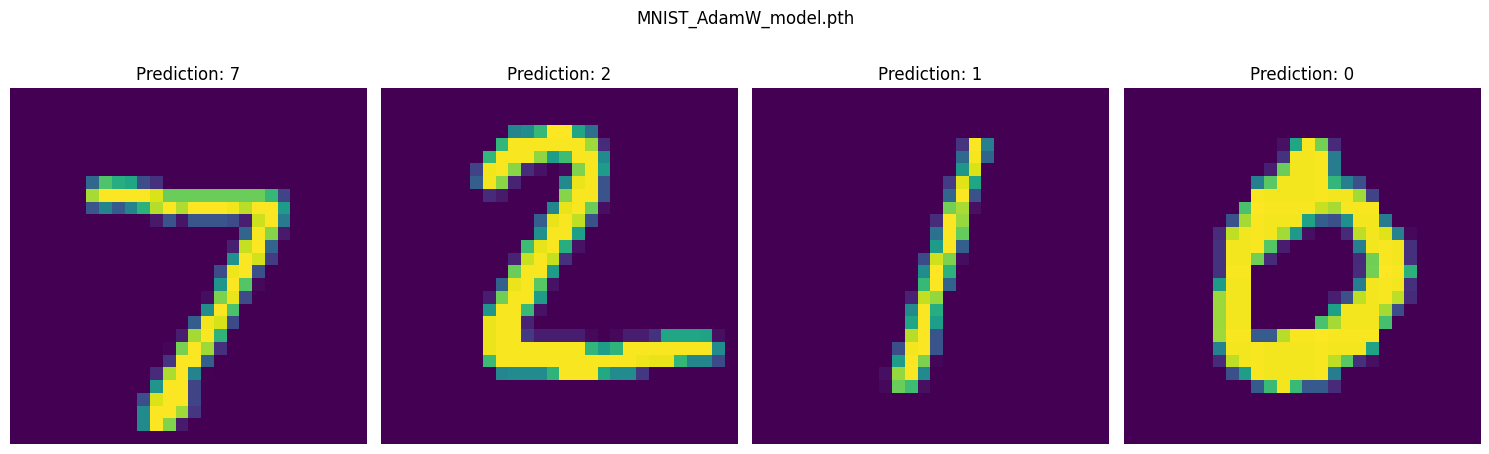

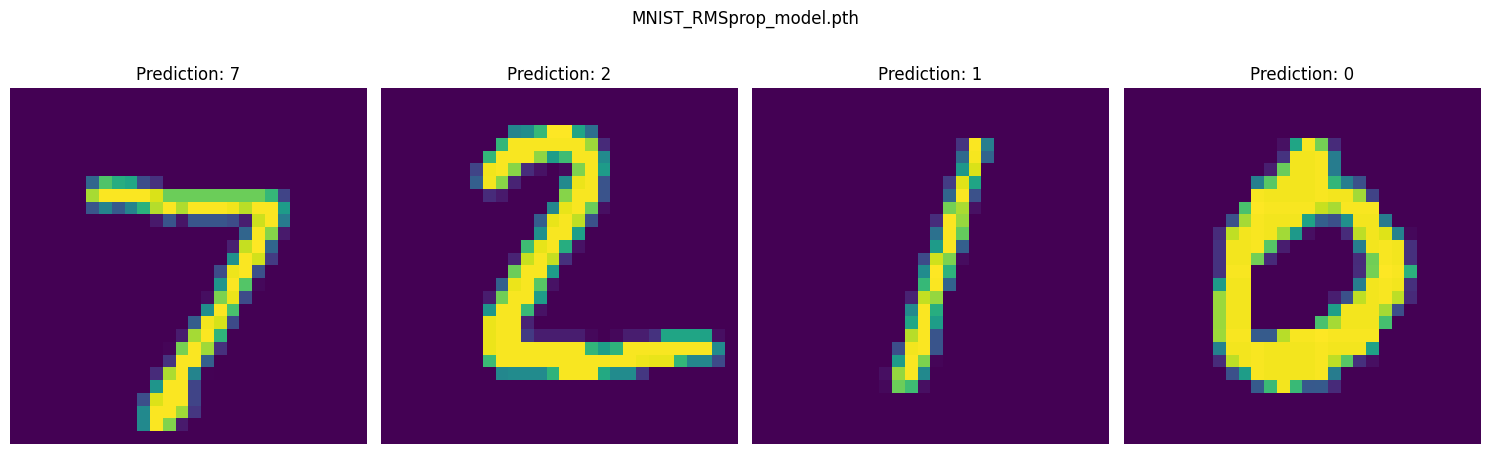

In [15]:
for dataset_name, dataset in datasets.items():
    print(f"DATASET: {dataset_name}")
    train_loader, valid_loader = get_dataset(dataset)

    for optimizer_name in optimizers:
        model = CNNClassifier()
        model.load_state_dict(
            torch.load(
                f"{MODEL_PATH}/{dataset_name}_{optimizer_name}_model.pth", map_location=device
            )
        )
        model.to(device)
        model.eval()

        images, paths = get_validation_images_and_labels(valid_loader, num_images=5)
        image_predictions = {}

        for i, (image, path) in enumerate(zip(images, paths)):
            prediction = predict(image, model)
            image_predictions[i] = prediction

        fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
        if len(images) == 1:
            axes = [axes]

        fig.suptitle(f"{dataset_name}_{optimizer_name}_model.pth")
        for ax, image, i in zip(axes, images, range(len(images))):
            ax.imshow(image[0])
            if "Fashion" in dataset_name:
                ax.set_title(f"Prediction: {fashion_mnist_labels[image_predictions[i][0]]}")
            else:
                ax.set_title(f"Prediction: {image_predictions[i][0]}")
            ax.axis("off")
        plt.tight_layout()
        plt.savefig(f"{RESULT_PATH}/{dataset_name}_{optimizer_name}_model.png")
        plt.show()